In [1]:
import os, sys
root_dir = os.path.dirname(os.getcwd())
sys.path.append(root_dir)

import pandas as pd
import matplotlib.pyplot as plt
from configs import support_llms, support_llm_properties
import numpy as np
import matplotlib as mpl
import seaborn as sns

df  = pd.read_pickle(f"{root_dir}/results/results.pkl")

df.head()

,_runtime,_step,_timestamp,_wandb,accuracy,calibrated_accuracy,consistency_rate,train_acc,seed,wandb,...,dataset_name,peft_variant,max_new_tokens,not_load_model,theory_example,theory_version,train_ml_model,system_prompt_name,run_name,run_id
0,608.820065,1999.0,1.733363e+09,{'runtime': 608},0.49750,0.0275,0.0600,NaN,42,True,...,relca,pretrained,1000,False,False,v4,,evaluator,fancy-rain-1,rws7x1ty
1,752.265414,1999.0,1.733364e+09,{'runtime': 752},0.51425,0.0760,0.1235,NaN,42,True,...,relca,pretrained,1000,False,False,v4,,evaluator,misty-frost-2,9n1ogm1l
2,5171.656271,1999.0,1.733368e+09,{'runtime': 5171},0.49675,0.0385,0.0405,NaN,42,True,...,relca,pretrained,1000,False,False,v4,,evaluator,denim-jazz-3,3qi1ixru
3,273.379546,1999.0,1.733363e+09,{'runtime': 273},0.60700,0.4520,0.6900,NaN,42,True,...,relca,pretrained,1000,False,False,v4,,evaluator,likely-yogurt-5,spxsot9y
4,1997.155615,1999.0,1.733365e+09,{'runtime': 1997},0.51175,0.0305,0.0375,NaN,42,True,...,relca,pretrained,1000,False,False,v4,,evaluator,exalted-resonance-6,8ixjdl3c


In [2]:
def get_row(**kwargs):
    condition = None
    for key, value in kwargs.items():

        if condition is None:
            condition = df[key] == value
        else:
            condition &= df[key] == value
    return df[condition].reset_index(drop=True)

In [5]:
mllms = [
    "gpt-4o-mini",
    "gpt-4o",
    "Llama-3.2-11B-Vision-Instruct",
    "Llama-3.2-90B-Vision-Instruct",
    'Qwen2-VL-2B-Instruct',
    'Qwen2-VL-7B-Instruct',
    'Qwen2-VL-72B-Instruct',
    'gemini-1.5-flash',
    'gemini-1.5-pro',
    'pixtral-12b',
    'gemini-2.0-flash',
    'o1-2024-12-17',
    # 'o3-mini-2025-01-31',
    # 'o3-preview-2024-11-20',
]

llms = [
    'Qwen2.5-14B-Instruct',
    'Qwen2.5-72B-Instruct',
    "Llama-3.1-8B-Instruct",
    "Llama-3.1-70B-Instruct",
    "Mistral-7B-Instruct-v0.3",
    "Mixtral-8x22B-Instruct-v0.1",
    "Mistral-Large-Instruct-2407",
    "DeepSeek-R1-Distill-Qwen-32B",
    "DeepSeek-R1-Distill-Llama-70B",
]


def get_description(model_name):
    if model_name in llms:
        return "gemini-1.5-pro"
    else:
        return ""

def get_prompt_name(eval_mode, prompt_name):
    if eval_mode == "single":
        if prompt_name == "standard":
            return "single"
        elif prompt_name == "cot":
            return "single_cot"
        elif prompt_name == "theory":
            return "theory"
    else:
        if prompt_name == "standard":
            return "standard"
        elif prompt_name == "cot":
            return "cot"
        elif prompt_name == "theory":
            return "pairwise_theory"

def get_baseline_configs(
    model_name,
    eval_mode,
    dataset_name,
):
    return {
        "model_name": model_name,
        "description": get_description(model_name),
        "prompt_name": get_prompt_name(eval_mode, "standard"),
        "eval_mode": "pairwise",
        "peft_variant": "pretrained",
        "n_demos": 0 if eval_mode == "pairwise" else 2,
        "dataset_name": dataset_name,
    }   

def get_baseline(
    model_name,
    eval_mode,
    dataset_name,
):

    search_config = get_baseline_configs(model_name, eval_mode, dataset_name)
    return get_row(**search_config)["accuracy"].max()

def get_inference_time_adaptation(
    model_name,
    eval_mode,
    dataset_name,
):

    demo_list = [2, 4] if eval_mode == "pairwise" else [4, 6, 8]
    default_config = get_baseline_configs(model_name, eval_mode, dataset_name)
    
    best_acc = 0
    # search for icl
    for n_demos in demo_list:
        config = default_config.copy()
        config["n_demos"] = n_demos
        result = get_row(**config)
        if len(result) > 0 and "accuracy" in result.columns:
            if len(result) > 1: print(result)
            best_acc = max(best_acc, result["accuracy"].max())
        else:
            print(f"No acc found for {config}")
        

    # search for reasoning
    prompt_name = get_prompt_name(eval_mode, "cot")
    config = default_config.copy()
    config["prompt_name"] = prompt_name
    result = get_row(**config)
    if len(result) > 0 and "accuracy" in result.columns:
        if len(result) > 1: print(result)
        best_acc = max(best_acc, result["accuracy"].max())
    else:
        print(f"No acc found for {config}")

    return best_acc

def get_ours(
    model_name,
    eval_mode,
    dataset_name,
):
    config = get_baseline_configs(model_name, eval_mode, dataset_name)
    config["prompt_name"] = get_prompt_name(eval_mode, "theory")
    config["n_demos"] = 0
    del config["description"]
    return get_row(**config)["accuracy"].max()

def get_ft(
    model_name,
    eval_mode,
    dataset_name,
):
    config = get_baseline_configs(model_name, eval_mode, dataset_name)
    del config["peft_variant"]
    rows = get_row(**config)
    return rows[rows["peft_variant"] != "pretrained"]["accuracy"].max()

def get_ours_ft(
    model_name,
    eval_mode,
    dataset_name,
):
    config = get_baseline_configs(model_name, eval_mode, dataset_name)
    del config["peft_variant"]
    config["prompt_name"] = get_prompt_name(eval_mode, "theory")
    config["n_demos"] = 0
    return get_row(**config)["accuracy"].max()


No acc found for {'model_name': 'gpt-4o', 'description': '', 'prompt_name': 'single_cot', 'eval_mode': 'pairwise', 'peft_variant': 'pretrained', 'n_demos': 2, 'dataset_name': 'ours_v4'}
    _runtime   _step    _timestamp           _wandb  accuracy  \
0  12.523010  1999.0  1.733983e+09  {'runtime': 12}     0.536   
1   6.881032  1999.0  1.740354e+09   {'runtime': 6}     0.536   

   calibrated_accuracy  consistency_rate  train_acc  seed  wandb  ...  \
0                0.536               1.0        NaN    42   True  ...   
1                0.536               1.0        NaN    42   True  ...   

  dataset_name peft_variant  max_new_tokens  not_load_model  theory_example  \
0      ours_v4   pretrained            1000            True           False   
1      ours_v4   pretrained            1000            True           False   

  theory_version train_ml_model  system_prompt_name              run_name  \
0             v4                          evaluator     ethereal-moon-195   
1     

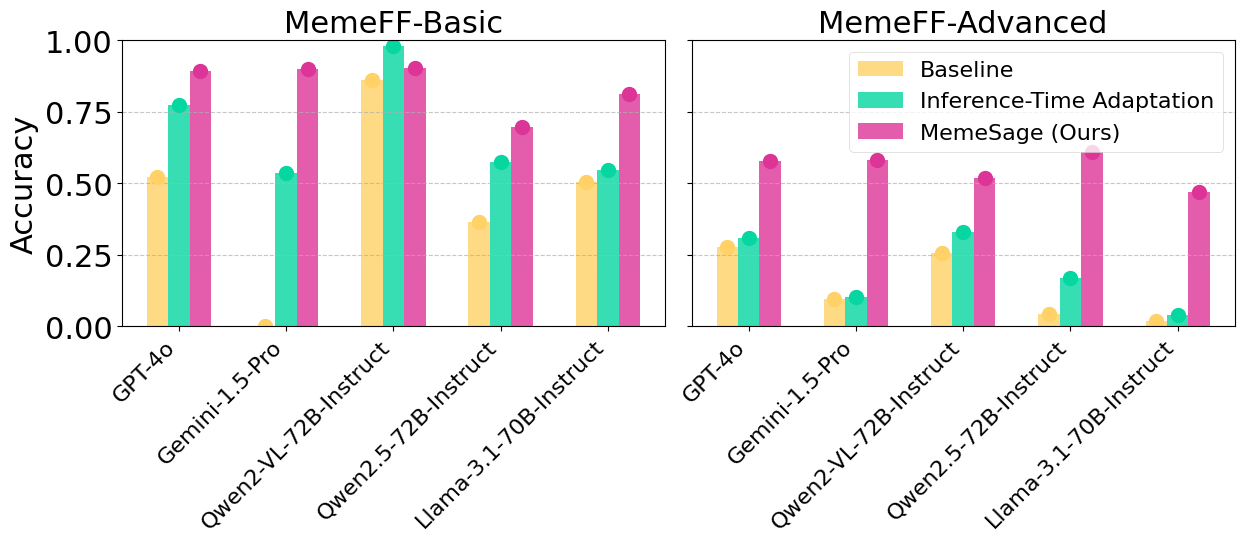

In [6]:
# Define the models, datasets, and evaluation modes
models = {
    "gpt-4o": "GPT-4o",
    "gemini-1.5-pro": "Gemini-1.5-Pro",
    "Qwen2-VL-72B-Instruct": "Qwen2-VL-72B-Instruct",
    "Qwen2.5-72B-Instruct": "Qwen2.5-72B-Instruct",
    "Llama-3.1-70B-Instruct": "Llama-3.1-70B-Instruct"
}
datasets = {"ours_v4": "MemeFF-Basic", "relca_v2": "MemeFF-Advanced"}
eval_mode = "single"  # Only using single evaluation mode

# Create a figure with 1x2 subplots (one for each dataset)
fig, axes = plt.subplots(1, 2, sharey=True)
plt.rc('xtick', labelsize=22)
plt.rc('ytick', labelsize=22)
mpl.rcParams['patch.linewidth']=0.5 #width of the boundary of legend
fig.subplots_adjust(left=0.1, bottom=0.4, right=0.99, top=0.92, wspace=0.05, hspace=0.15) #margin of the figure
fig.set_size_inches(12.5, 5.5) #exact size of the figure

# Set up the bar width and positions
bar_width = 0.2  # Reduced bar width to accommodate 3 bars
index = np.arange(len(models))

# Colors for different methods
colors = ['#FFD166', '#06D6A0', '#DD3497'] 

# Iterate through datasets to create each subplot
for i, dataset in enumerate(datasets):
    ax = axes[i]
    
    # Lists to store results for each method
    baseline_results = []       
    adaptation_results = []
    ours_results = []
    
    # Get results for each model
    for model in models:
        # Get baseline accuracy
        baseline_acc = get_baseline(model, eval_mode, dataset)
        baseline_results.append(baseline_acc)
        
        # Get inference time adaptation accuracy
        adaptation_acc = get_inference_time_adaptation(model, eval_mode, dataset)
        adaptation_results.append(adaptation_acc)
        
        # Get our method accuracy
        ours_acc = get_ours(model, eval_mode, dataset)
        ours_results.append(ours_acc)
    
    # Create the bar plots with alpha=0.6
    baseline_bars = ax.bar(index - bar_width, baseline_results, bar_width, label='Baseline', color=colors[0], alpha=0.8)
    adaptation_bars = ax.bar(index, adaptation_results, bar_width, label='Inference-Time Adaptation', color=colors[1], alpha=0.8)
    ours_bars = ax.bar(index + bar_width, ours_results, bar_width, label='MemeSage (Ours)', color=colors[2], alpha=0.8)
    
    # Add dots on top of each bar with the same color as the bar
    for j, value in enumerate(baseline_results):
        ax.plot(index[j] - bar_width, value, 'o', color=colors[0], markersize=10)
    
    for j, value in enumerate(adaptation_results):
        ax.plot(index[j], value, 'o', color=colors[1], markersize=10)
    
    for j, value in enumerate(ours_results):
        ax.plot(index[j] + bar_width, value, 'o', color=colors[2], markersize=10)
    
    ax.set_title(f'{datasets[dataset]}', fontsize=22)
    ax.set_xticks(index)
    ax.set_xticklabels(models.values(), rotation=45, ha='right', fontsize=16)
    
    # Set y-axis limits
    ax.set_ylim(0, 1.0)
    
    # Add grid for better readability
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    if i == 0:
        ax.set_ylabel('Accuracy', fontsize=22)

ax.legend(fontsize=16, loc = "upper right")
plt.savefig(f"{root_dir}/figures/memesage_independent_eval.pdf")
